# setup

In [34]:
import numpy  as np
import pandas as pd
import os

import hashlib
import datetime
import warnings
import pickle
import gc

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn           as sns

from sklearn.datasets import make_classification
from sklearn.metrics import brier_score_loss

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import normalize, StandardScaler
from sklearn.metrics         import classification_report, roc_curve, auc,accuracy_score, confusion_matrix, f1_score, fbeta_score
from sklearn.calibration     import CalibratedClassifierCV, calibration_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import datetime
import gc
import json
import os
import pprint
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.preprocessing import MinMaxScaler

from IPython.display import display

mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings("ignore")

%matplotlib inline

In [35]:
sns.set_style("whitegrid")

plt.rcParams.update({
    'font.size'       : 9,
    'figure.figsize'  : (3.5, 2.8),
    'figure.dpi'      : 300,
    'savefig.dpi'     : 300,
    'text.usetex'     : True,
    'font.family'     : 'serif',
    'font.serif'      : ['Times New Roman'],
    'axes.labelsize'  : 9,
    'axes.titlesize'  : 9,
    'xtick.labelsize' : 8,
    'ytick.labelsize' : 8,
    'legend.fontsize' : 8,
    'lines.linewidth' : 1,
    'axes.linewidth'  : 1,
    'grid.linestyle'  : '--',
    'grid.linewidth'  : 0.5,
    'grid.alpha'      : 0.8,
})

sns.set_context(
    "paper", 
    rc={
        "font.size"      : 9,
        "axes.titlesize" : 9,
        "axes.labelsize" : 9, 
        'xtick.labelsize': 8,
        'ytick.labelsize': 8
    }
)

In [36]:
golden_ratio = (np.sqrt(5) - 1) / 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [37]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

# interpolation

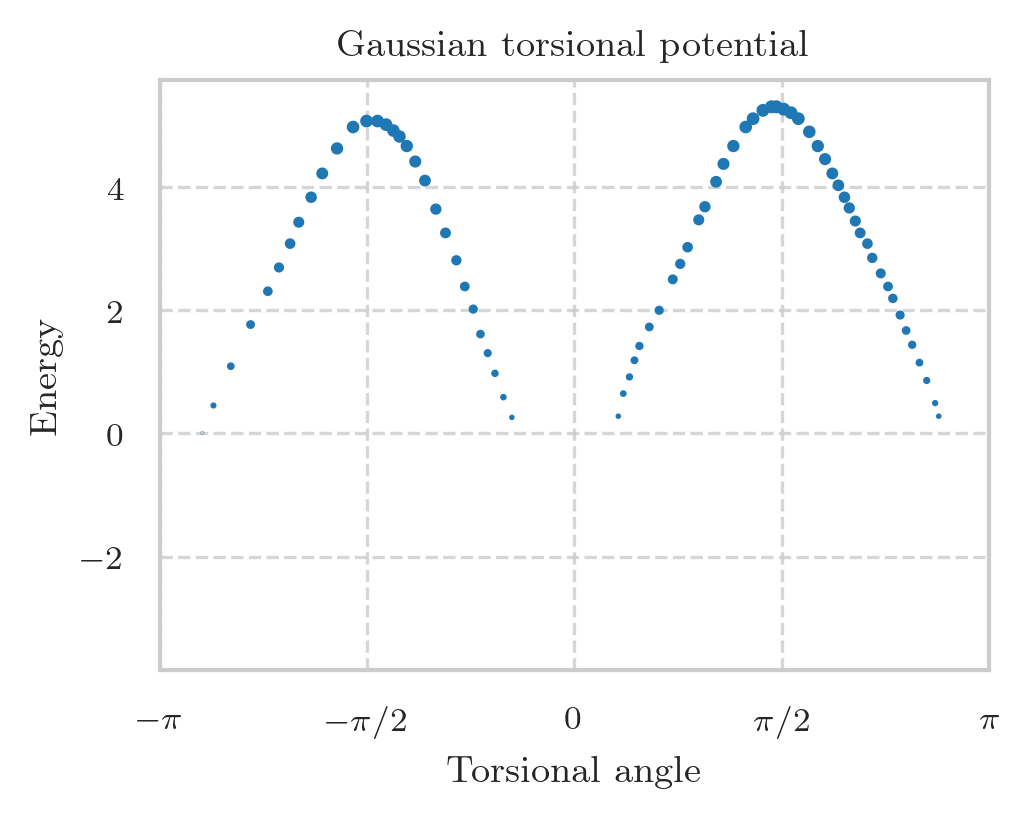

In [190]:
df = pd.read_csv("~/Downloads/Gaussian_torsional (1).csv", delimiter=";", header=None, decimal=',')
df[[0, 1]] = df[[0, 1]].astype(np.float64)
df[0] = np.radians(df[0])

df.plot(x=0, y=1, kind='scatter', s=1)

plt.xlabel('Torsional angle')
plt.xlim(-np.pi, np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])

plt.ylabel('Energy')

plt.title('Gaussian torsional potential')
plt.tight_layout()

In [191]:
def network_training(data, hyperparameters):
    """
    network_training
    """    
    torch.manual_seed(0)
    np.random.seed(0)
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)

    x_train = torch.tensor(data["x"].values).float().unsqueeze(1).to(device)
    y_train = torch.tensor(data["y"].values).float().unsqueeze(1).to(device)

    hparam_dict = {
        'lambda_physics_loss' : hyperparameters['lambda_physics_loss'],
        'learning_rate': hyperparameters['learning_rate'],
        'n_layers': hyperparameters['n_layers'],
        'n_neurons': hyperparameters['n_neurons'],
        'num_epochs': hyperparameters['num_epochs'],
        'num_collocation_points': hyperparameters['num_collocation_points'],
        'activation': hyperparameters['activation'],
    }
    _architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]
    _collocation = torch.linspace(0, 90, hparam_dict["num_collocation_points"]).view(-1,1).requires_grad_(True).to(device)

    pprint.pprint(hparam_dict)

    model = MultiLayerPerceptronRegressor(_architecture, hparam_dict["activation"]).to(device)
    optimizer = optim.Adam(
        [
            {"params": model.parameters()}, 
        ], 
        lr=hparam_dict["learning_rate"]
    )
    criterion = nn.MSELoss()

    plot_loss_train = dict(
        epoch=list(),
        dataloss=list(), 
        physicsloss=list(), 
        k=list()
    )
    for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
        optimizer.zero_grad()

        # forward
        y_train_hat = model(x_train)
        data_loss = criterion(y_train_hat, y_train)

        loss = data_loss #+ hparam_dict["lambda_physics_loss"]*(physics_loss + _T0_loss)
        
        # backward
        loss.backward()
        optimizer.step()
    
    gc.collect()

    return loss.item()

In [192]:
param_grid = {
    'lambda_physics_loss' : [0.0001, 0.001, 0.01, 0.1, 1],
    'learning_rate': [0.00001, 0.0001, 0.001, 0.1],
    'n_layers': [2, 3, 4, 5],
    'n_neurons': [8, 16, 32, 64, 128],
    'num_epochs': [100, 1000, 10000],
    'num_collocation_points': [10, 20, 30, 40, 50],
    'activation': [nn.Tanh, nn.ELU, nn.LeakyReLU, nn.ReLU]
}

In [193]:
X = df.rename(columns={0: "x", 1: "y"}).copy()

In [194]:
# np.random.seed(33)

# for _index, _hparam in enumerate(np.random.choice(ParameterGrid(param_grid), 100, replace=False)):
#     print(f"trial {_index+1}, {datetime.datetime.now()}")
#     pprint.pprint(network_training(X.copy(), _hparam))
#     print()

In [195]:
_hparam = {
    'activation': nn.LeakyReLU,
    'lambda_physics_loss': 0.0001,
    'learning_rate': 0.0001,
    'n_layers': 4,
    'n_neurons': 128,
    'num_collocation_points': 20,
    'num_epochs': 10000
}

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

x_train = torch.tensor(X["x"].values).float().unsqueeze(1).to(device)
y_train = torch.tensor(X["y"].values).float().unsqueeze(1).to(device)

hparam_dict = {
    'activation': nn.LeakyReLU,
    'lambda_physics_loss': 0.0001,
    'learning_rate': 0.0001,
    'n_layers': 4,
    'n_neurons': 64,
    'num_collocation_points': 20,
    'num_epochs': 30000
}
_architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]
_collocation = torch.linspace(0, 90, hparam_dict["num_collocation_points"]).view(-1,1).requires_grad_(True).to(device)

pprint.pprint(hparam_dict)

model = MultiLayerPerceptronRegressor(_architecture, hparam_dict["activation"]).to(device)
optimizer = optim.Adam(
    [
        {"params": model.parameters()}, 
    ], 
    lr=hparam_dict["learning_rate"]
)
criterion = nn.MSELoss()

plot_loss_train = dict(
    epoch=list(),
    dataloss=list(), 
    physicsloss=list(), 
    k=list()
)
for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    optimizer.zero_grad()

    # forward
    y_train_hat = model(x_train)
    data_loss = criterion(y_train_hat, y_train)

    loss = data_loss #+ hparam_dict["lambda_physics_loss"]*(physics_loss + _T0_loss)
    
    # backward
    loss.backward()
    optimizer.step()

gc.collect()

print(f"loss: {loss.item()}")

{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.0001,
 'n_layers': 4,
 'n_neurons': 64,
 'num_collocation_points': 20,
 'num_epochs': 30000}


  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [00:40<00:00, 747.64it/s] 


loss: 0.00019592429453041404


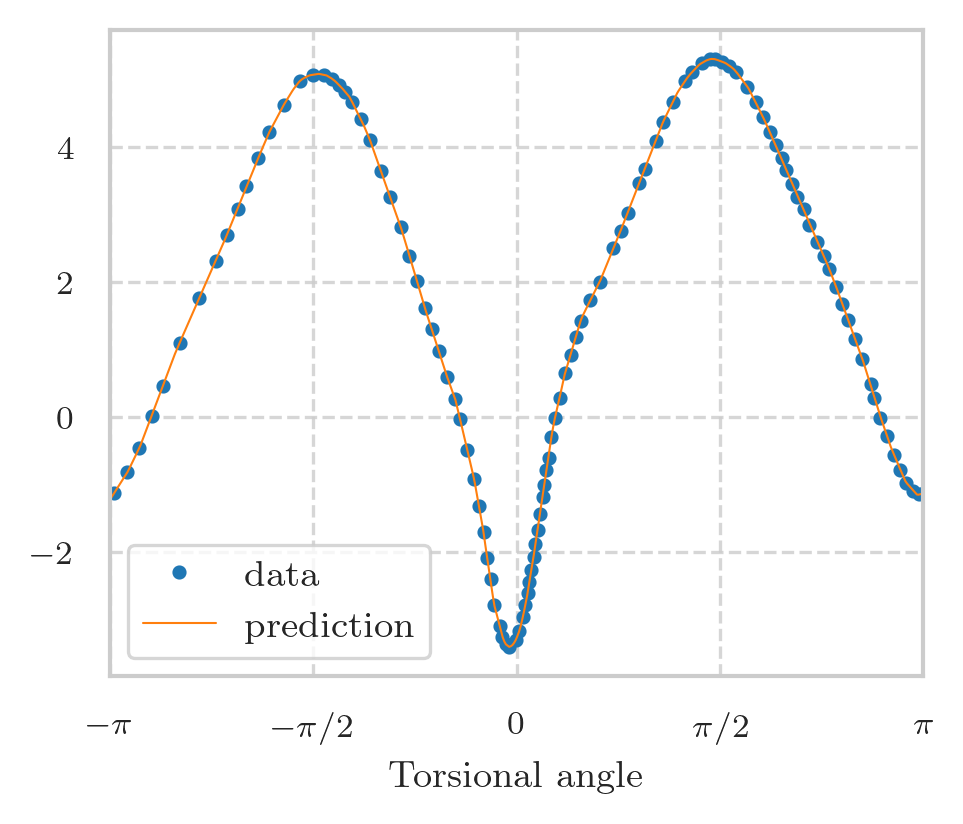

In [196]:
fig, ax = plt.subplots(1, 1)

model.eval()

with torch.no_grad():
    x_pred = torch.linspace(-np.pi, np.pi, 500).view(-1,1)
    y_pred = model(x_pred.to(device))

ax.plot(x_train.cpu().numpy(), y_train.cpu().numpy(), '.', label='data')
ax.plot(x_pred.cpu().numpy(), y_pred.cpu().numpy(), label='prediction', linewidth=0.5)

ax.set_xlabel('Torsional angle')
ax.set_xlim(-np.pi, np.pi)
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])

plt.legend() ;

# parameter learning

$V_{rb}\left(\phi_{ijkl}\right) = \frac{1}{2} \left[ F_1\left( 1 + cos(\phi_1) \right) + F_2\left( 1 - cos(2\phi_2) \right) + F_3\left( 1 + cos(3\phi_3) \right) + F_4\left( 1 - cos(4\phi_4) \right) \right]$

,14-13-9-4,14-13-9-11,17-13-9-4,17-13-9-11,14-13-9-4_hat,14-13-9-11_hat,17-13-9-4_hat,17-13-9-11_hat
0,-2.545737,0.603360,0.648739,-2.545737,1.341553,1.856151,2.033091,1.341553
1,-2.371204,0.777893,0.823272,-2.371204,2.105034,2.639401,2.857661,2.105034
2,-2.196671,0.952426,0.997805,-2.196671,2.888368,3.494330,3.717643,2.888368
3,-2.022138,1.126959,1.172338,-2.022138,3.707893,4.353226,4.535872,3.707893
4,-1.847606,1.301492,1.346871,-1.847606,4.444600,4.982395,5.094402,4.444600
5,-1.673073,1.476025,1.521404,-1.673073,4.980142,5.293148,5.305850,4.980142
6,-1.498540,1.650558,1.695936,-1.498540,5.075954,5.197584,5.116039,5.075954
7,-1.324007,1.825091,1.870469,-1.324007,4.821873,4.743215,4.570704,4.821873
8,-1.149474,1.999624,2.045002,-1.149474,4.186510,4.030459,3.829976,4.186510
9,-0.974941,2.174157,2.219535,-0.974941,3.254153,3.259367,3.058884,3.254153


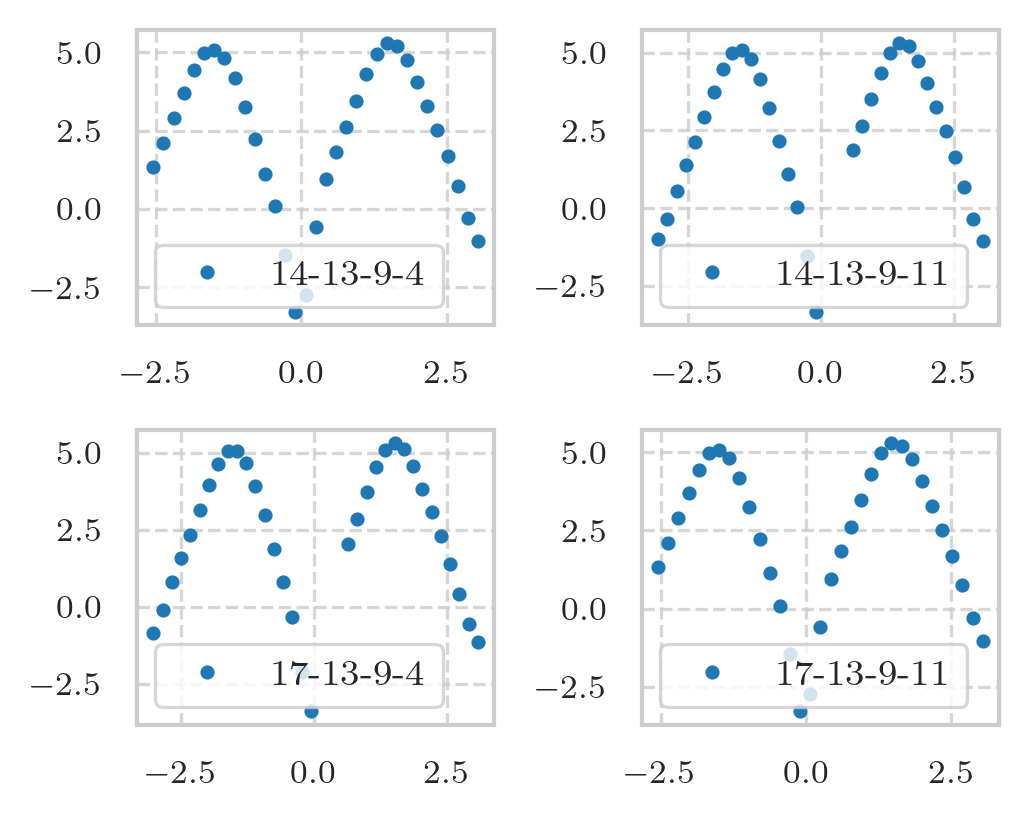

In [199]:
df = pd.read_csv("~/Downloads/parametrizacao_ff (1).csv", delimiter=",", decimal=',')
df = df.transform(lambda x: np.radians(x))

for c in df.columns:
    with torch.no_grad():
        df[f"{c}_hat"] = model(torch.tensor(df[c].values).float().unsqueeze(1).to(device)).cpu().numpy()

display(df)

fig, axs = plt.subplots(2,2)

axs[0,0].plot(df["14-13-9-4"], df["14-13-9-4_hat"], '.', label='14-13-9-4')
axs[0,1].plot(df["14-13-9-11"], df["14-13-9-11_hat"], '.', label='14-13-9-11')
axs[1,0].plot(df["17-13-9-4"], df["17-13-9-4_hat"], '.', label='17-13-9-4')
axs[1,1].plot(df["17-13-9-11"], df["17-13-9-11_hat"], '.', label='17-13-9-11')
axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()

plt.tight_layout()


In [200]:
X = df.copy()

# phi_1 = 0
# phi_2 = 0
# phi_3 = 0
# phi_4 = 0

# for c in X.drop(columns=["ans"]).columns:
#     X[f"{c}_V1"] = 0.5 * (1 + np.cos(1 * np.radians(X[c]) - phi_1))
#     X[f"{c}_V2"] = 0.5 * (1 - np.cos(2 * np.radians(X[c]) - phi_2))
#     X[f"{c}_V3"] = 0.5 * (1 + np.cos(3 * np.radians(X[c]) - phi_3))
#     X[f"{c}_V4"] = 0.5 * (1 - np.cos(4 * np.radians(X[c]) - phi_4)) 
#     X = X.drop(columns=[c])

In [201]:
gc.collect()

35028

In [206]:
pred_cols = df.filter(like="_hat").columns.tolist()
train_cols = df.drop(columns=pred_cols).columns.tolist()

print(train_cols)
print(pred_cols)

['14-13-9-4', '14-13-9-11', '17-13-9-4', '17-13-9-11']
['14-13-9-4_hat', '14-13-9-11_hat', '17-13-9-4_hat', '17-13-9-11_hat']


In [207]:
x_train = torch.tensor(X[train_cols].values).float().to(device)
y_train = torch.tensor(X[pred_cols].values).float().to(device)

In [223]:
_hparam = {
    'activation': nn.LeakyReLU,
    'lambda_physics_loss': 0.0001,
    'learning_rate': 0.0001,
    'n_layers': 4,
    'n_neurons': 128,
    'num_collocation_points': 20,
    'num_epochs': 10000
}

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

hparam_dict = {
    'activation': nn.LeakyReLU,
    'lambda_physics_loss': 0.0001,
    'learning_rate': 0.001,
    'n_layers': 4,
    'n_neurons': 32,
    'num_collocation_points': 20,
    'num_epochs': 30000
}
_architecture = [len(train_cols)] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [len(pred_cols)]

_F1 = torch.tensor(0.5, dtype=torch.float32, requires_grad=True, device=device)
_F2 = torch.tensor(0.5, dtype=torch.float32, requires_grad=True, device=device)
_F3 = torch.tensor(0.5, dtype=torch.float32, requires_grad=True, device=device)
_F4 = torch.tensor(0.5, dtype=torch.float32, requires_grad=True, device=device)

pprint.pprint(hparam_dict)

model = MultiLayerPerceptronRegressor(_architecture, hparam_dict["activation"]).to(device)
optimizer = optim.Adam(
    [
        {"params": model.parameters()}, 
        {"params": [_F1, _F2, _F3, _F4]}
    ], 
    lr=hparam_dict["learning_rate"]
)
criterion = nn.MSELoss()

plot_loss_train = dict(
    epoch=list(),
    dataloss=list(), 
    physicsloss=list(), 
    k=list()
)
for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    optimizer.zero_grad()

    # forward
    y_train_hat = model(x_train)
    
    data_loss = criterion(y_train_hat, y_train)

    v1_loss = criterion(
        y_train[:,0],
        0.5 * ( _F1*(1 + torch.cos(1 * x_train[:,0])) + _F2*(1 - torch.cos(2 * x_train[:,0])) + _F3*(1 + torch.cos(3 * x_train[:,0])) + _F4*(1 - torch.cos(4 * x_train[:,0])) )
    )

    loss = data_loss + v1_loss
    
    # backward
    loss.backward()
    optimizer.step()

    if epoch % 5000 == 0:
        print(f"epoch: {epoch}, loss: {loss.item()}, F1: {_F1.item()}, F2: {_F2.item()}, F3: {_F3.item()}, F4: {_F4.item()}")

gc.collect()

print(f"loss: {loss.item()}")

{'activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
 'lambda_physics_loss': 0.0001,
 'learning_rate': 0.001,
 'n_layers': 4,
 'n_neurons': 32,
 'num_collocation_points': 20,
 'num_epochs': 30000}


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 41/30000 [00:00<01:14, 404.11it/s]

epoch: 0, loss: 17.8935604095459, F1: 0.5009999871253967, F2: 0.5009999871253967, F3: 0.5009999871253967, F4: 0.5009999871253967


 17%|█▋        | 5096/30000 [00:08<00:40, 613.27it/s]

epoch: 5000, loss: 0.6936702728271484, F1: -0.5046146512031555, F2: 4.478543758392334, F3: -0.6675509810447693, F4: 0.9098072052001953


 34%|███▎      | 10116/30000 [00:16<00:31, 622.56it/s]

epoch: 10000, loss: 0.25555965304374695, F1: -0.9431151747703552, F2: 6.058675289154053, F3: -1.1209708452224731, F4: 0.42650121450424194


 50%|█████     | 15063/30000 [00:24<00:24, 608.02it/s]

epoch: 15000, loss: 0.2564501464366913, F1: -0.9435701966285706, F2: 6.060310363769531, F3: -1.12144136428833, F4: 0.4260072410106659


 67%|██████▋   | 20112/30000 [00:31<00:15, 657.07it/s]

epoch: 20000, loss: 0.25556719303131104, F1: -0.9435946345329285, F2: 6.060314178466797, F3: -1.1214654445648193, F4: 0.4259859025478363


 84%|████████▎ | 25086/30000 [00:40<00:06, 735.97it/s]

epoch: 25000, loss: 0.25555604696273804, F1: -0.9435636401176453, F2: 6.060321807861328, F3: -1.1214343309402466, F4: 0.42601412534713745


100%|██████████| 30000/30000 [00:47<00:00, 635.87it/s]

loss: 0.25555485486984253


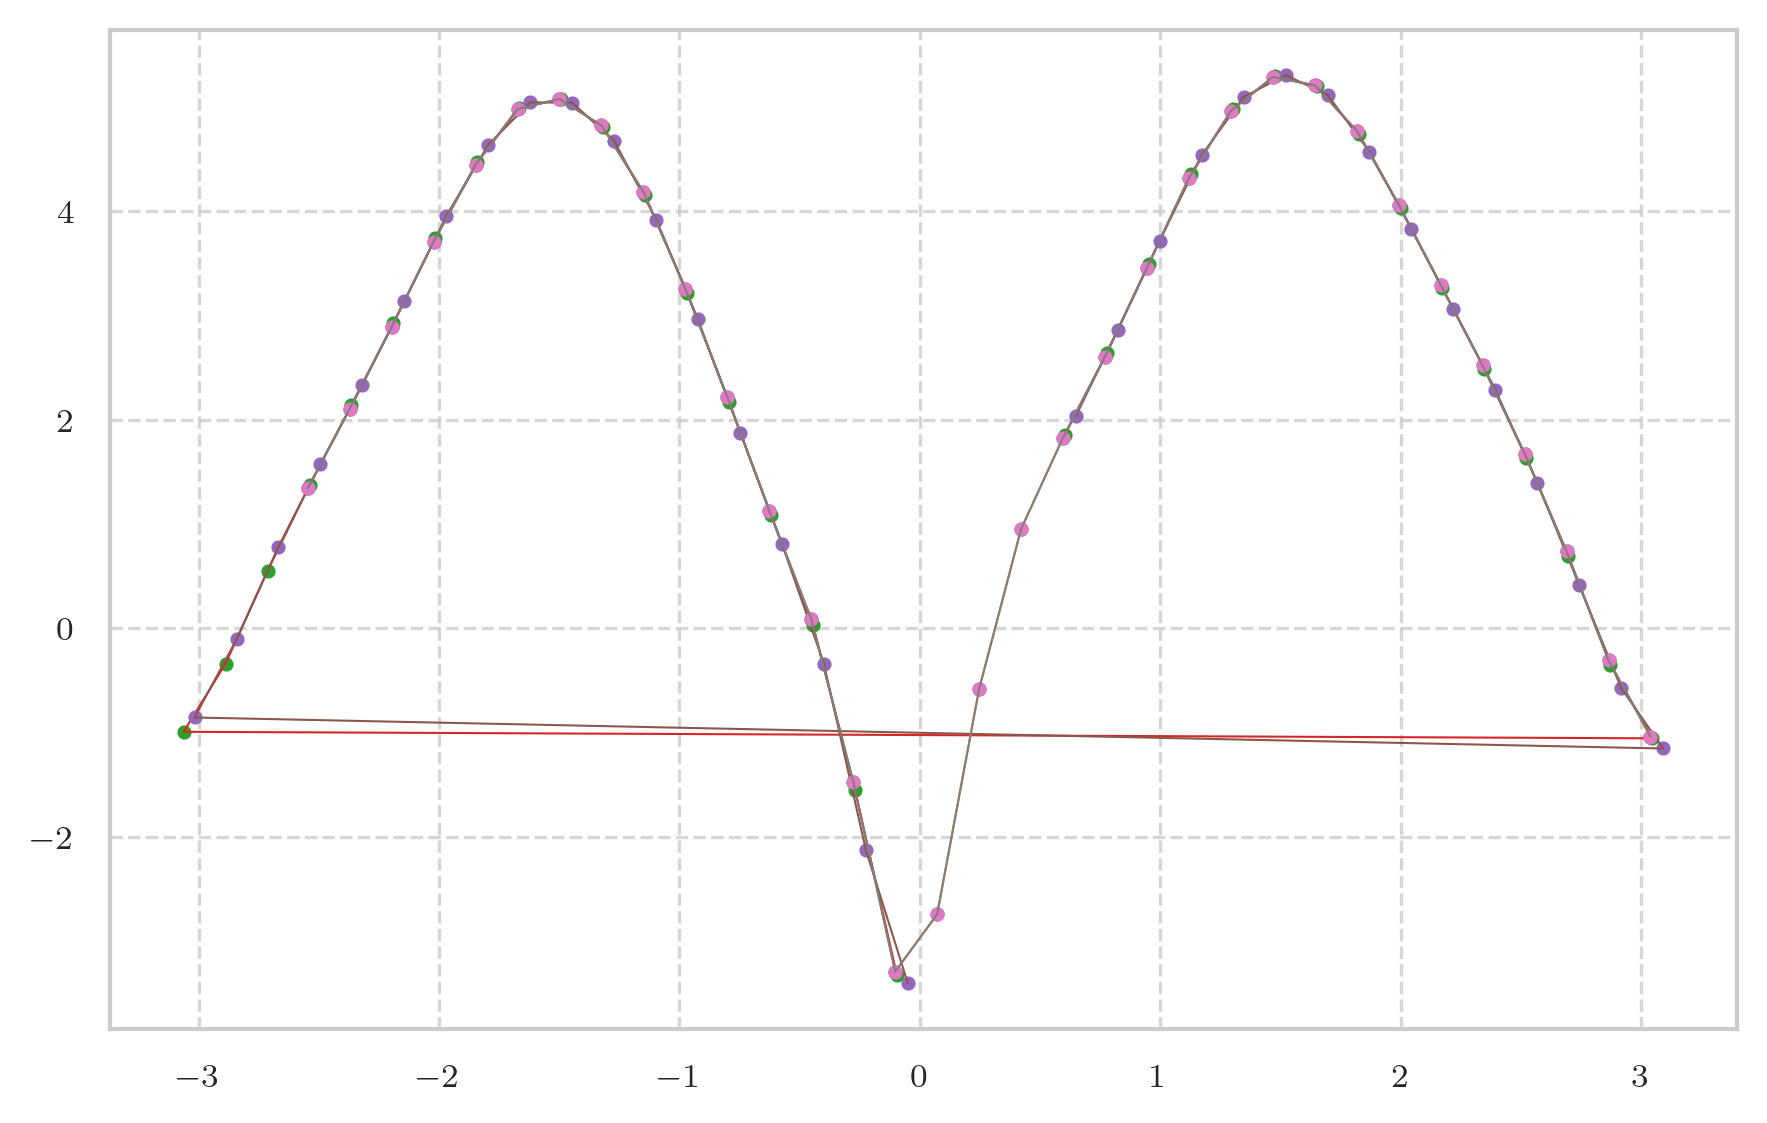

In [225]:
fig, ax = plt.subplots(1, 1, figsize=(7, golden_ratio*7))
model.eval()

F1 = _F1.item()
F2 = _F2.item()
F3 = _F3.item()
F4 = _F4.item()

with torch.no_grad():
    ax.plot(x_train.cpu().numpy()[:,0], y_train.cpu().numpy()[:,0], '.', label='data')
    ax.plot(x_train.cpu().numpy()[:,0], model(x_train).cpu().numpy()[:,0], label='prediction', linewidth=0.5)

    ax.plot(x_train.cpu().numpy()[:,1], y_train.cpu().numpy()[:,1], '.', label='data')
    ax.plot(x_train.cpu().numpy()[:,1], model(x_train).cpu().numpy()[:,1], label='prediction', linewidth=0.5)
    
    ax.plot(x_train.cpu().numpy()[:,2], y_train.cpu().numpy()[:,2], '.', label='data')
    ax.plot(x_train.cpu().numpy()[:,2], model(x_train).cpu().numpy()[:,2], label='prediction', linewidth=0.5)

    ax.plot(x_train.cpu().numpy()[:,3], y_train.cpu().numpy()[:,3], '.', label='data')
    ax.plot(x_train.cpu().numpy()[:,3], model(x_train).cpu().numpy()[:,3], label='prediction', linewidth=0.5)

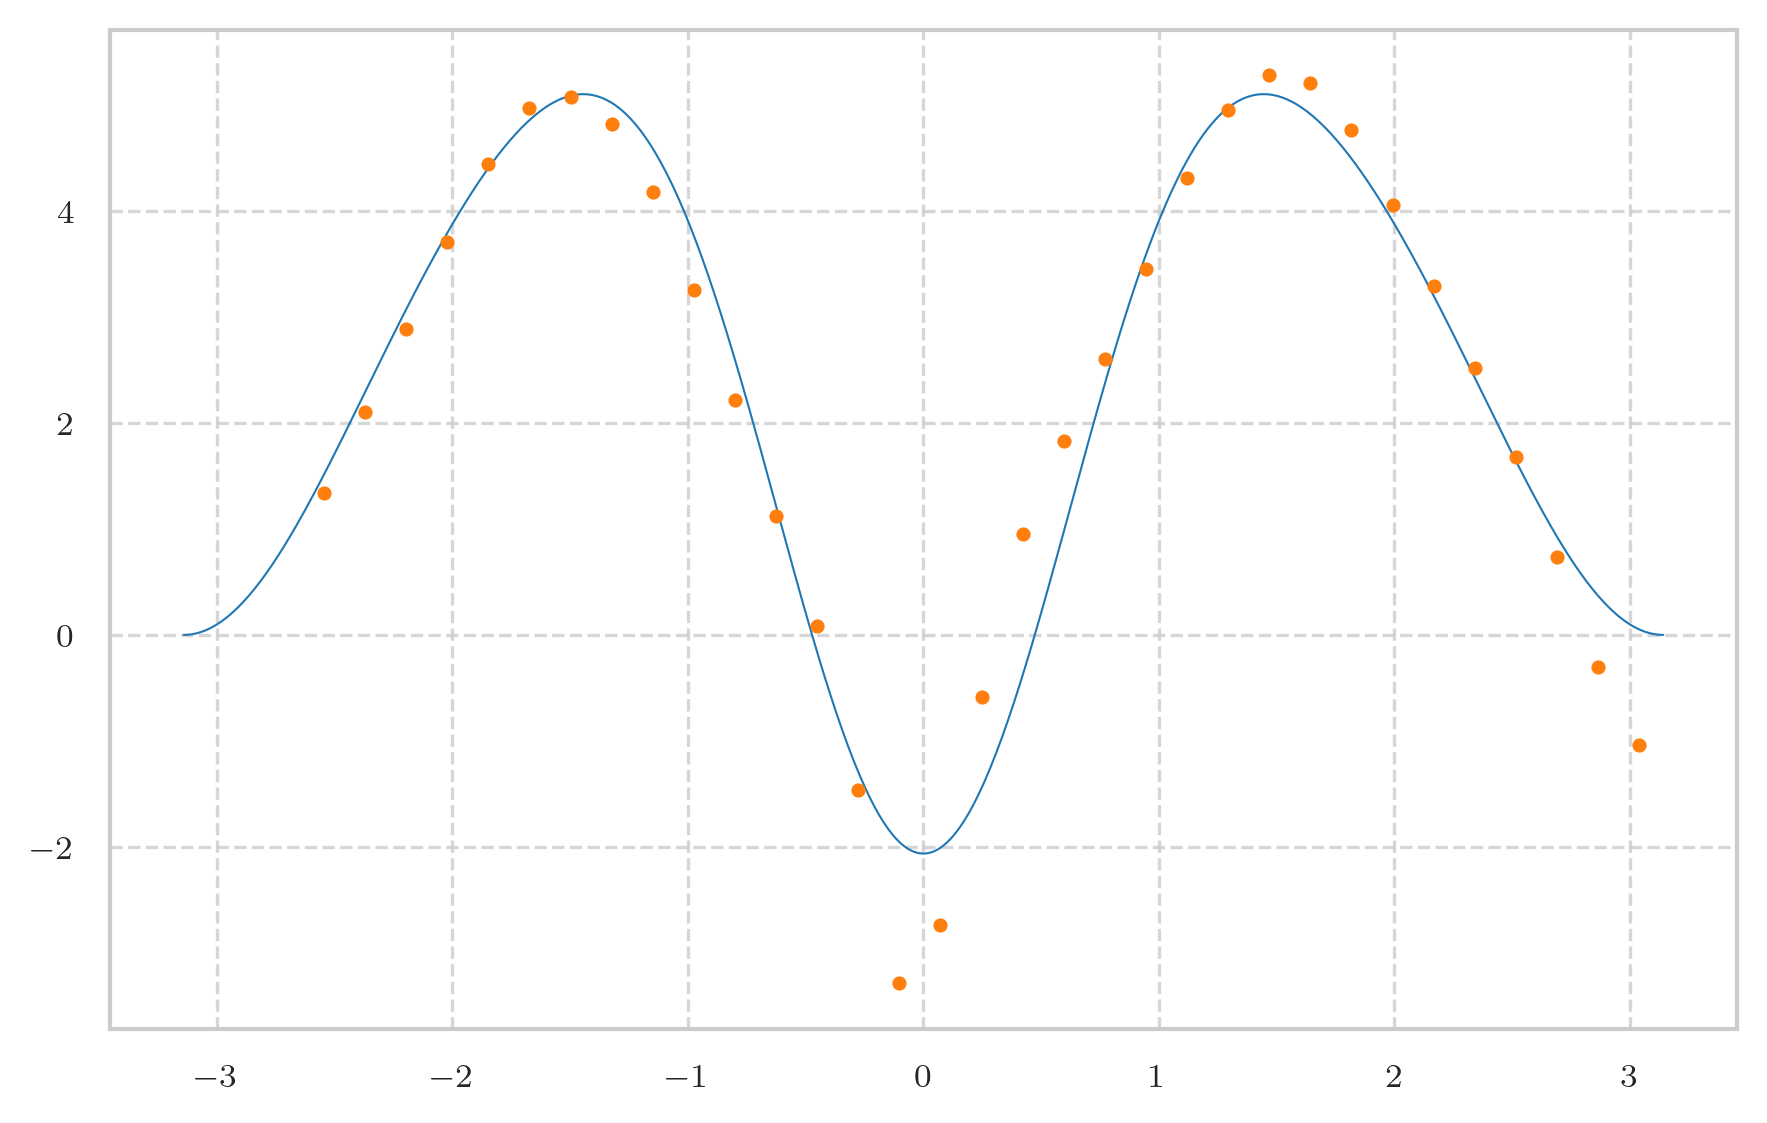

In [228]:
fig, ax = plt.subplots(1, 1, figsize=(7, golden_ratio*7))
model.eval()

F1 = _F1.item()
F2 = _F2.item()
F3 = _F3.item()
F4 = _F4.item()

with torch.no_grad():
    x_pred = np.linspace(-np.pi, np.pi, 500).reshape(-1,1)
    y_fit =  0.5 * ( F1*(1 + np.cos(1 * x_pred)) + F2*(1 - np.cos(2 * x_pred)) + F3*(1 + np.cos(3 * x_pred)) + F4*(1 - np.cos(4 * x_pred)) )
    ax.plot(x_pred, y_fit, label='prediction', linewidth=0.5)
    ax.plot(x_train.cpu().numpy()[:,0], y_train.cpu().numpy()[:,0], '.', label='data')


In [163]:
y_model[:,0,:]

array([[-0.05618903],
       [-0.05556112],
       [-0.05648841],
       [-0.05947854],
       [-0.06462058],
       [-0.07128421],
       [-0.07816148],
       [-0.0837822 ],
       [-0.08717397],
       [-0.08817729],
       [-0.08727972],
       [-0.08521932],
       [-0.0826603 ],
       [-0.08006033],
       [-0.07767855],
       [-0.230625  ],
       [-0.22995323],
       [-0.22847514],
       [-0.22635143],
       [-0.22385858],
       [-0.22138162],
       [-0.2193649 ],
       [-0.21819575],
       [-0.21801335],
       [-0.21852605],
       [-0.2190133 ],
       [-0.21862052],
       [-0.21678913],
       [-0.21349405],
       [-0.20914064],
       [-0.20428047],
       [-0.19938192],
       [-0.1947437 ]], dtype=float32)

In [158]:
x_train[:,:,0]

tensor([[-2.5457],
        [-2.3712],
        [-2.1967],
        [-2.0221],
        [-1.8476],
        [-1.6731],
        [-1.4985],
        [-1.3240],
        [-1.1495],
        [-0.9749],
        [-0.8004],
        [-0.6259],
        [-0.4513],
        [-0.2768],
        [-0.1023],
        [ 0.0723],
        [ 0.2468],
        [ 0.4213],
        [ 0.5959],
        [ 0.7704],
        [ 0.9449],
        [ 1.1195],
        [ 1.2940],
        [ 1.4685],
        [ 1.6431],
        [ 1.8176],
        [ 1.9921],
        [ 2.1667],
        [ 2.3412],
        [ 2.5157],
        [ 2.6903],
        [ 2.8648],
        [ 3.0393]], device='cuda:0')

.